Hello Michael!

I’m happy to review your project today.
I will mark your mistakes and give you some hints how it is possible to fix them. We are getting ready for real job, where your team leader/senior colleague will do exactly the same. Don't worry and study with pleasure!

Below you will find my comments - **please do not move, modify or delete them**.

You can find my comments in green, yellow or red boxes like this:

<div class="alert alert-block alert-success">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

Success. Everything is done succesfully.
</div>

<div class="alert alert-block alert-warning">
<b>Reviewer's comment</b> <a class="tocSkip"></a>

Remarks. Some recommendations.
</div>

<div class="alert alert-block alert-danger">

<b>Reviewer's comment</b> <a class="tocSkip"></a>

Needs fixing. The block requires some corrections. Work can't be accepted with the red comments.
</div>

You can answer me by using this:

<div class="alert alert-block alert-info">
<b>Student answer.</b> <a class="tocSkip"></a>

Text here.
</div>

<div class="alert alert-block alert-info">
<b>Welcome!</b> <a class="tocSkip"></a>
Welcome to my project. 

Due to the size of the datasets run time is roughly fifteen minutes. To reduce runtime some sacrifices have been made:
    <ul>
        <li> Limited charts, especially in exploratory data analysis.</li>
        <li> Rougher fill of missing values.</li>
        <li> Rougher modeling.</li>
    </ul>
Have a great day,
</div>

# Title
Zyfra Prototype Gold Recovery Machine Learning Model

# Description

Prepare a prototype of a machine learning model for Zyfra. The company develops efficiency solutions for heavy industry.

The model should predict the amount of gold recovered from gold ore. You have the data on extraction and purification.

The model will help to optimize the production and eliminate unprofitable parameters.

# Prodcedure
1. Prepare the data
- 1.1. Open the files and look into the data.
- 1.2. Check that recovery is calculated correctly. Using the training set, calculate recovery for the rougher.output.recovery feature. Find the MAE between your calculations and the feature values. Provide findings.
- 1.3. Analyze the features not available in the test set. What are these parameters? What is their type?
- 1.4. Perform data preprocessing.
2. Analyze the data
- 2.1. Take note of how the concentrations of metals (Au, Ag, Pb) change depending on the purification stage.
- 2.2. Compare the feed particle size distributions in the training set and in the test set. If the distributions vary significantly, the model evaluation will be incorrect.
- 2.3. Consider the total concentrations of all substances at different stages: raw feed, rougher concentrate, and final concentrate. Do you notice any abnormal values in the total distribution? If you do, is it worth removing such values from both samples? Describe the findings and eliminate anomalies. 
3. Build the model
- 3.1. Write a function to calculate the final sMAPE value.
- 3.2. Train different models. Evaluate them using cross-validation. Pick the best model and test it using the test sample. Provide findings.


- au - gold
- pb - lead


In [1]:
# Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.stats import zscore

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint  # for random parameter distributions

# Import ML models from scikit-learn
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
#from sklearn.linear_model import RandomForestRegressor  # or any other model you want to try

from sklearn.model_selection import GridSearchCV


# Import other utility functions from scikit-learn
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler


Create functions for common tasks:

In [2]:
def describe_df(df, title):
    display(title)
    display(df.describe())
    print()

In [3]:
# Function to do basic exploration of datasets:

def explore_df(df, title, detailed=True):
    print(title)
    print()
    print(f'{title} - shape: {df.shape}')
    print(f'{title} - Number of duplicates: {df.duplicated().sum()}') ##### RUN THIS LATER
    print(f'{title} - Number of null entries: {df.isna().sum().sum()}') ##### RUN THIS LATER
    print()
    if (detailed==True):
        print(df.info())
        print()
        #print(df.head(0))
        #print()
        describe_df(df, title)
        print()


In [4]:
def plot_hist_bar(df, title):
    # Plot histograms of the columns
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    sns.histplot(df, bins=30, ax=axes[0], kde=True)
    axes[0].set_title(title)
    
    sns.boxplot(ax=axes[1], data=df)
    axes[1].set_title(title)
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [5]:
def plot_kde_compare(df0, df1, col, title, xlabel, df0label='Train', df1label='Test'):
    # Plotting distributions
    sns.kdeplot(df0[col], color='blue', alpha=0.5, label=df0label)
    sns.kdeplot(df1[col], color='red', alpha=0.5, label=df1label)
    plt.legend()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.tight_layout()
    plt.show()

In [6]:
# A function to filter datasets by a string in the column

def filter_by_cols(df, search_string):    

    filtered_df = pd.DataFrame()

    # Filter columns containing the search string
    filtered_columns = [col for col in df.columns if search_string in col]

    if not filtered_columns:
        return filtered_df

    filtered_df = df[filtered_columns]

    #col_list = filtered_df.columns.tolist() ##### MIGHT DO THIS OUT OF FUNCTION

    # Display the filtered DataFrame
    return filtered_df

## Prepare the data

1. Prepare the data
- 1.1. Open the files and look into the data.
- 1.2. Check that recovery is calculated correctly. Using the training set, calculate recovery for the rougher.output.recovery feature. Find the MAE between your calculations and the feature values. Provide findings.
- 1.3. Analyze the features not available in the test set. What are these parameters? What is their type?
- 1.4. Perform data preprocessing.

### Open the files and look into the data.

In [7]:
# Import data

df_train = pd.read_csv('/datasets/gold_recovery_train.csv')
df_test = pd.read_csv('/datasets/gold_recovery_test.csv')
df_full = pd.read_csv('/datasets/gold_recovery_full.csv')

In [8]:
explore_df(df_train, 'Training dataset')
explore_df(df_test, 'Testing dataset')
explore_df(df_full, 'Full dataset')

Training dataset

Training dataset - shape: (16860, 87)
Training dataset - Number of duplicates: 0
Training dataset - Number of null entries: 30320

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.ou

'Training dataset'

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,16788.000000,16788.000000,16490.000000,16789.000000,15339.000000,16794.000000,16677.000000,16715.000000,16794.000000,15553.000000,...,16731.000000,16747.000000,16768.000000,16767.000000,16775.000000,16775.000000,16775.000000,16776.000000,16757.000000,16775.000000
mean,4.716907,9.113559,8.301123,39.467217,67.213166,8.757048,2.360327,9.303932,2.687512,129.479789,...,19.101874,-494.164481,14.778164,-476.600082,15.779488,-500.230146,12.377241,-498.956257,18.429208,-521.801826
std,2.096718,3.389495,3.825760,13.917227,11.960446,3.634103,1.215576,4.263208,1.272757,45.386931,...,6.883163,84.803334,5.999149,89.381172,6.834703,76.983542,6.219989,82.146207,6.958294,77.170888
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000003,...,0.000000,-799.920713,0.000000,-800.021781,-0.423260,-799.741097,0.427084,-800.258209,0.024270,-810.473526
25%,3.971262,8.825748,6.939185,42.055722,62.625685,7.610544,1.641604,7.870275,2.172953,103.064021,...,14.508299,-500.837689,10.741388,-500.269182,10.977713,-500.530594,8.925586,-500.147603,13.977626,-501.080595
50%,4.869346,10.065316,8.557228,44.498874,67.644601,9.220393,2.453690,10.021968,2.781132,131.783108,...,19.986958,-499.778379,14.943933,-499.593286,15.998340,-499.784231,11.092839,-499.933330,18.034960,-500.109898
75%,5.821176,11.054809,10.289741,45.976222,72.824595,10.971110,3.192404,11.648573,3.416936,159.539839,...,24.983961,-494.648754,20.023751,-400.137948,20.000701,-496.531781,15.979467,-498.418000,24.984992,-499.565540
max,16.001945,17.031899,18.124851,53.611374,100.000000,19.552149,6.086532,22.317730,9.789625,251.999948,...,60.000000,-127.692333,28.003828,-71.472472,63.116298,-275.073125,39.846228,-120.190931,54.876806,-39.784927




Testing dataset

Testing dataset - shape: (5856, 53)
Testing dataset - Number of duplicates: 0
Testing dataset - Number of null entries: 2360

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_clean

'Testing dataset'

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5554.000000,5572.000000,5856.000000,5690.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,...,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000
mean,170.515243,8.482873,7.264651,1.321420,1481.990241,-509.057796,1486.908670,-511.743956,1468.495216,-509.741212,...,15.636031,-516.266074,13.145702,-476.338907,12.308967,-512.208126,9.470986,-505.017827,16.678722,-512.351694
std,49.608602,3.353105,0.611526,0.693246,310.453166,61.339256,313.224286,67.139074,309.980748,62.671873,...,4.660835,62.756748,4.304086,105.549424,3.762827,58.864651,3.312471,68.785898,5.404514,69.919839
min,0.000103,0.000031,5.650000,0.000003,0.000000,-799.773788,0.000000,-800.029078,0.000000,-799.995127,...,0.000000,-799.798523,0.000000,-800.836914,-0.223393,-799.661076,0.528083,-800.220337,-0.079426,-809.859706
25%,143.340022,6.411500,6.885625,0.888769,1497.190681,-500.455211,1497.150234,-500.936639,1437.050321,-501.300441,...,12.057838,-501.054741,11.880119,-500.419113,10.123459,-500.879383,7.991208,-500.223089,13.012422,-500.833821
50%,176.103893,8.023252,7.259333,1.183362,1554.659783,-499.997402,1553.268084,-500.066588,1546.160672,-500.079537,...,17.001867,-500.160145,14.952102,-499.644328,12.062877,-500.047621,9.980774,-500.001338,16.007242,-500.041085
75%,207.240761,10.017725,7.650000,1.763797,1601.681656,-499.575313,1601.784707,-499.323361,1600.785573,-499.009545,...,18.030985,-499.441529,15.940011,-401.523664,15.017881,-499.297033,11.992176,-499.722835,21.009076,-499.395621
max,274.409626,40.024582,15.500000,5.433169,2212.432090,-57.195404,1975.147923,-142.527229,1715.053773,-150.937035,...,30.051797,-401.565212,31.269706,-6.506986,25.258848,-244.483566,14.090194,-126.463446,26.705889,-29.093593




Full dataset

Full dataset - shape: (22716, 87)
Full dataset - Number of duplicates: 0
Full dataset - Number of null entries: 36587

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb  

'Full dataset'

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,22627.000000,22629.000000,22331.000000,22630.000000,20753.000000,22633.000000,22516.000000,22445.000000,22635.000000,21107.000000,...,22571.000000,22587.000000,22608.000000,22607.000000,22615.000000,22615.000000,22615.000000,22616.000000,22597.000000,22615.000000
mean,4.781559,9.095308,8.640317,40.001172,67.447488,8.923690,2.488252,9.523632,2.827459,140.277672,...,18.205125,-499.878977,14.356474,-476.532613,14.883276,-503.323288,11.626743,-500.521502,17.976810,-519.361465
std,2.030128,3.230797,3.785035,13.398062,11.616034,3.517917,1.189407,4.079739,1.262834,49.919004,...,6.560700,80.273964,5.655791,93.822791,6.372811,72.925589,5.757449,78.956292,6.636203,75.477151
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000003,...,0.000000,-799.920713,0.000000,-800.836914,-0.423260,-799.741097,0.427084,-800.258209,-0.079426,-810.473526
25%,4.018525,8.750171,7.116799,42.383721,63.282393,7.684016,1.805376,8.143576,2.303108,110.177081,...,14.095940,-500.896232,10.882675,-500.309169,10.941299,-500.628697,8.037533,-500.167897,13.968418,-500.981671
50%,4.953729,9.914519,8.908792,44.653436,68.322258,9.484369,2.653001,10.212998,2.913794,141.330501,...,18.007326,-499.917108,14.947646,-499.612292,14.859117,-499.865158,10.989756,-499.951980,18.004215,-500.095463
75%,5.862593,10.929839,10.705824,46.111999,72.950836,11.084557,3.287790,11.860824,3.555077,174.049914,...,22.998194,-498.361545,17.977502,-400.224147,18.014914,-498.489381,14.001193,-499.492354,23.009704,-499.526388
max,16.001945,17.031899,19.615720,53.611374,100.000000,19.552149,6.086532,22.861749,9.789625,274.409626,...,60.000000,-127.692333,31.269706,-6.506986,63.116298,-244.483566,39.846228,-120.190931,54.876806,-29.093593


Initial observations in all datasets:
- The datasets are large, with many columns
- All the date columns are of type object
- There are no fully duplicated rows
- There are a large number of null entries

### Check that recovery is calculated correctly. Using the training set, calculate recovery for the rougher.output.recovery feature. Find the MAE between your calculations and the feature values. Provide findings.

Recovery calculation

You need to simulate the process of recovering gold from gold ore.
Use the following formula to simulate the recovery process:

Recovery = ((C * (F - T)) / (F * (C - T))) * 100%

where:

- C — share of gold (AU) in the concentrate right after flotation (for finding the rougher concentrate recovery)/after purification (for finding the final concentrate recovery)
- F — share of gold (AU) in the feed before flotation (for finding the rougher concentrate recovery)/in the concentrate right after flotation (for finding the final concentrate recovery)
- T — share of gold (AU) in the rougher tails right after flotation (for finding the rougher concentrate recovery)/after purification (for finding the final concentrate recovery)

To predict the coefficient, you need to find the share of gold in the concentrate and the tails. Note that both final and rougher concentrates matter.

In [9]:
rougher_recovery_cols = ['rougher.output.recovery', 'rougher.input.feed_au', 'rougher.output.concentrate_au', 'rougher.output.tail_au']

print('Null values in recover calculation data:')
print(df_train[rougher_recovery_cols].isna().sum())
print()
print('The calculation will be verified by ignoring any null values.')

Null values in recover calculation data:
rougher.output.recovery          2573
rougher.input.feed_au              83
rougher.output.concentrate_au      82
rougher.output.tail_au           2249
dtype: int64

The calculation will be verified by ignoring any null values.


In [10]:
def recovery_calculation(df, title):
    df = df.dropna()
    F = df['rougher.input.feed_au']
    C = df['rougher.output.concentrate_au']
    T = df['rougher.output.tail_au']
    recovery =  ((C * (F - T)) / (F * (C - T))) * 100
    mae = mean_absolute_error(df['rougher.output.recovery'], recovery)

    print(f'{title} - Recovery Calculation')
    print(f"Mean Absolute Error: {mae:.2f}")
    return recovery


In [11]:
recovery = recovery_calculation(df_train, 'Training Set')

Training Set - Recovery Calculation
Mean Absolute Error: 0.00


The calculation is performing as expected. However, and in addition to the null values discussed above, there are a significant number of zero values. These may represent issues with the data or can cause errors in the calculation.

<div class="alert alert-block alert-success">
<b>Reviewer's comment V1</b> <a class="tocSkip"></a>
    
Good job!
    
</div>

In [12]:
print('Zero values in recover calculation data:')
print((df_train[rougher_recovery_cols]==0).sum())
print(f"C - rougher.output.concentrate_au - results in a 0 in the numerator")
print(f"F - rougher.input.feed_au - results in a 0 in the denominator")

Zero values in recover calculation data:
rougher.output.recovery           320
rougher.input.feed_au            1159
rougher.output.concentrate_au    1493
rougher.output.tail_au              0
dtype: int64
C - rougher.output.concentrate_au - results in a 0 in the numerator
F - rougher.input.feed_au - results in a 0 in the denominator


The training data set also included a calcualtion of AU:PB

In [13]:
def calculation_au_pb_ratio(df, title):
    au_pb_ratio_cols = ['rougher.input.feed_au', 'rougher.input.feed_pb', 'rougher.calculation.au_pb_ratio']
    
    df = df.dropna()
    au = df['rougher.input.feed_au']
    pb = df['rougher.input.feed_pb']
    
    ratio_au_pb =  au / pb

    print(f'{title} - AU:PB Calculation')
    mae = mean_absolute_error(df['rougher.calculation.au_pb_ratio'], ratio_au_pb)
    print(f"Mean Absolute Error: {mae:.2f}")

calculation_au_pb_ratio(df_train, 'Training Set')

Training Set - AU:PB Calculation
Mean Absolute Error: 0.00


### Analyze the features not available in the test set. What are these parameters? What is their type?


In [14]:
def get_uncommon_cols(df0, df1, display=True):
    
    # Get the list of columns in all dfs:
    df0_cols = set(df0.columns.tolist())
    df1_cols = set(df1.columns.tolist())

    # Find differences:

    uncommon_features = sorted(list(df0_cols-df1_cols))
    #common_features = sorted(list(df0_cols & df1_cols))

    # Display differences:
    if (display == True):
        print('Features in the training set but not in the test set:')
        print()
        print(df_train[uncommon_features].info())
        print()
    
    return uncommon_features

In [15]:
uncommon_features = get_uncommon_cols(df_train, df_test)

Features in the training set but not in the test set:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 34 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         16788 non-null  float64
 1   final.output.concentrate_au                         16789 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.recovery                               15339 non-null  float64
 5   final.output.tail_ag                                16794 non-null  float64
 6   final.output.tail_au                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol

Some parameters are not available because they were measured and/or calculated much later.
That's why, some of the features that are present in the training set may be absent from the test set.
The test set also doesn't contain targets.

To proceed with training and testing of the models, both training set and test set must use the same features.

<div class="alert alert-block alert-success">
<b>Reviewer's comment V1</b> <a class="tocSkip"></a>
    
Correct
    
</div>

### Perform data preprocessing.

Issues that have been identified:
- Null and zero values will be addressed in subsequent steps
- Date columns are type object

In [16]:
explore_df(df_train, 'Training Set', detailed=False)
explore_df(df_test, 'Testing Set', detailed=False)
explore_df(df_full, 'Full Set', detailed=False)

Training Set

Training Set - shape: (16860, 87)
Training Set - Number of duplicates: 0
Training Set - Number of null entries: 30320

Testing Set

Testing Set - shape: (5856, 53)
Testing Set - Number of duplicates: 0
Testing Set - Number of null entries: 2360

Full Set

Full Set - shape: (22716, 87)
Full Set - Number of duplicates: 0
Full Set - Number of null entries: 36587



In [17]:
# Convert to datetime

df_train['date'] = pd.to_datetime(df_train['date'], utc=True, errors='coerce')
df_test['date'] = pd.to_datetime(df_test['date'], utc=True, errors='coerce')
df_full['date'] = pd.to_datetime(df_full['date'], utc=True, errors='coerce')

## Analyze the data

### Take note of how the concentrations of metals (Au, Ag, Pb) change depending on the purification stage.

In [18]:
def get_particle_concentrate(df, plot=True):

    df_metal_total = pd.DataFrame()

    au_concentrate = filter_by_cols(df, 'concentrate_au')
    df_metal_total['concentrate_au'] = au_concentrate.sum(axis=1)

    ag_concentrate = filter_by_cols(df, 'concentrate_ag')
    df_metal_total['concentrate_ag'] = ag_concentrate.sum(axis=1)

    pb_concentrate = filter_by_cols(df, 'concentrate_pb')
    df_metal_total['concentrate_pb'] = pb_concentrate.sum(axis=1)

    # Plot results

    if ((plot == True) & (len(df_metal_total) > 0)):

        plot_hist_bar(au_concentrate, 'AU Concentrate')
        plot_hist_bar(df_metal_total['concentrate_au'], 'Total AU Concentrate')
        
        plot_hist_bar(ag_concentrate, 'AG Concentrate')
        plot_hist_bar(df_metal_total['concentrate_ag'], 'Total AG Concentrate')
        
        plot_hist_bar(pb_concentrate, 'PB Concentrate')
        plot_hist_bar(df_metal_total['concentrate_pb'], 'Total PB Concentrate')
        
        #plot_hist_bar(sol_concentrate, 'SOL Concentrate')
        #plot_hist_bar(df['total_concentrate_sol'], 'Total SOL Concentrate')
        
        #plot_hist_bar(get_concentrate_total(df), 'Concentrate Total')

    return df_metal_total


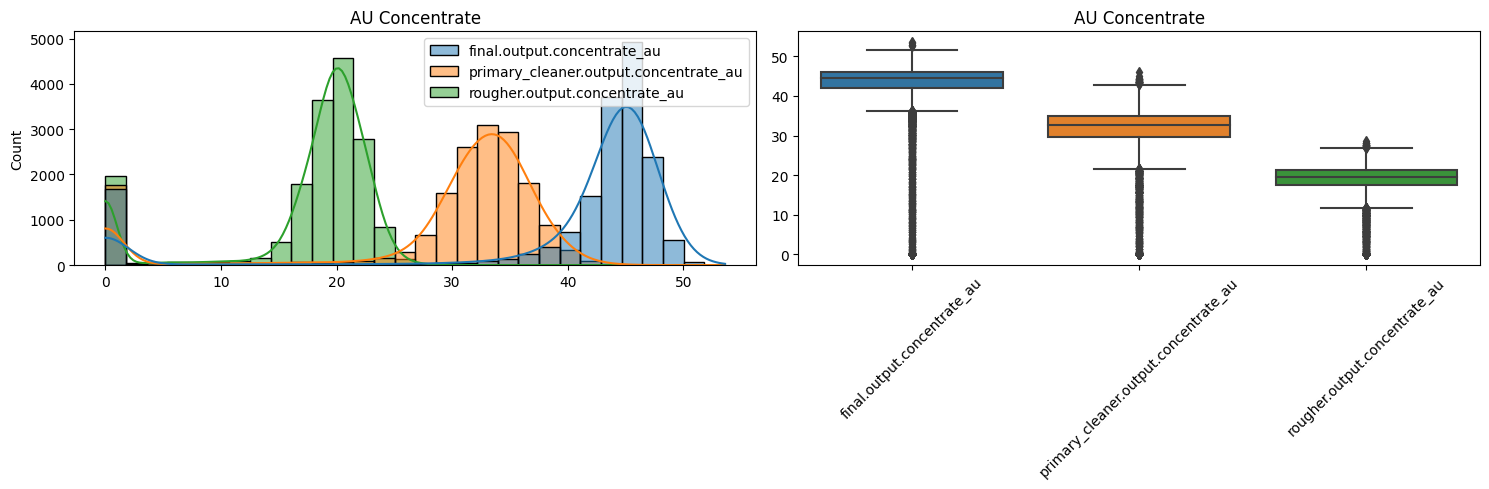

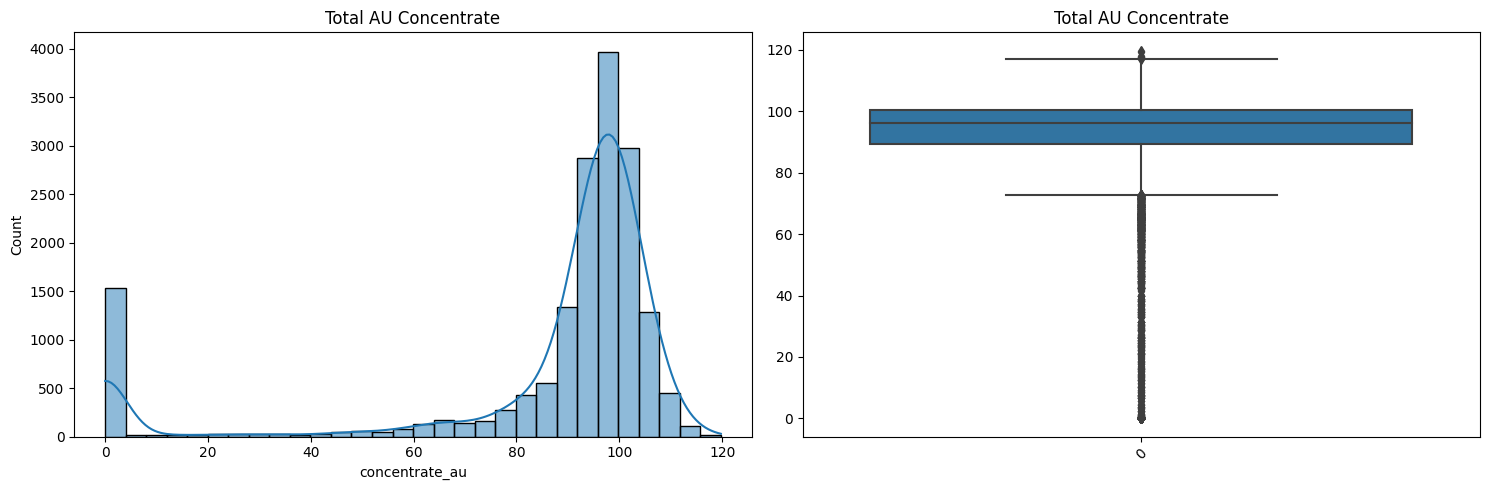

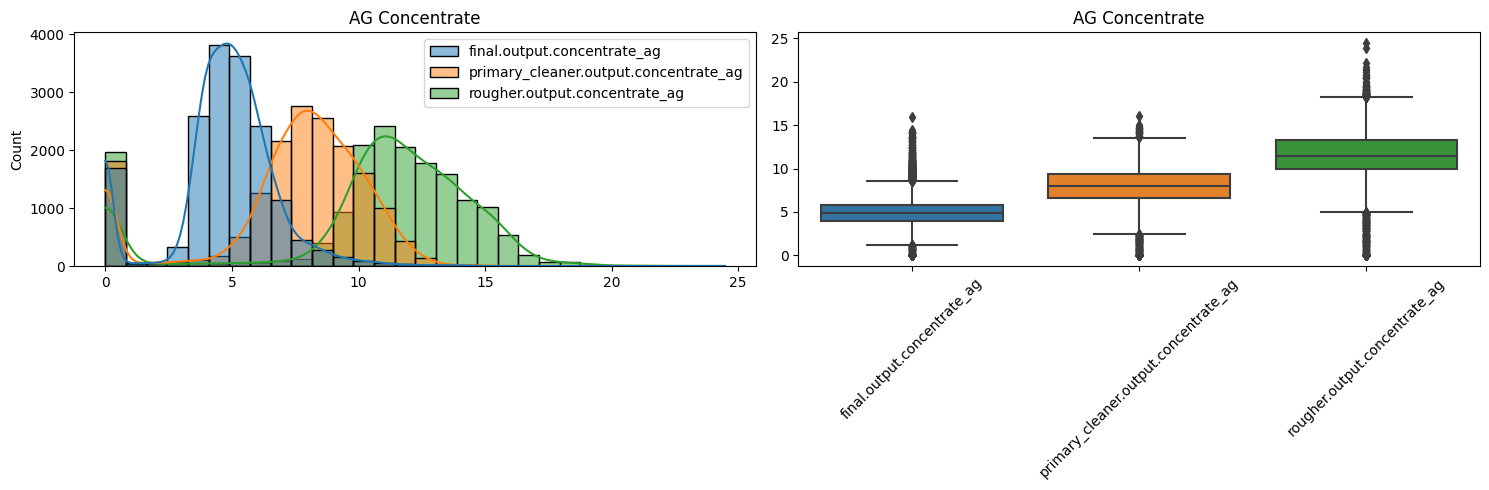

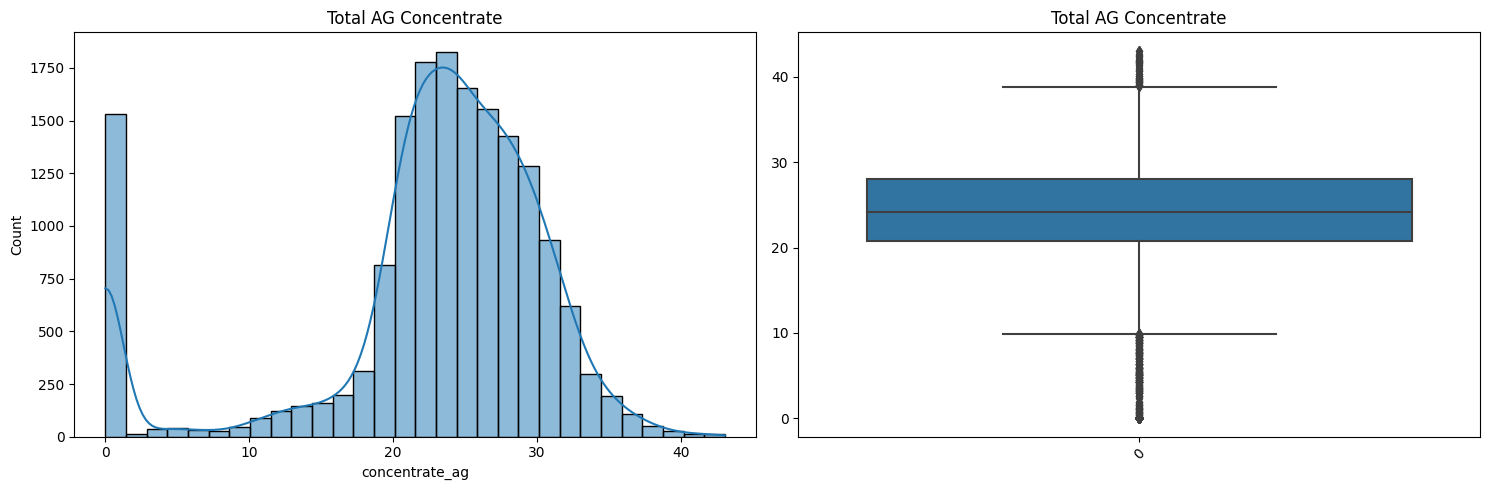

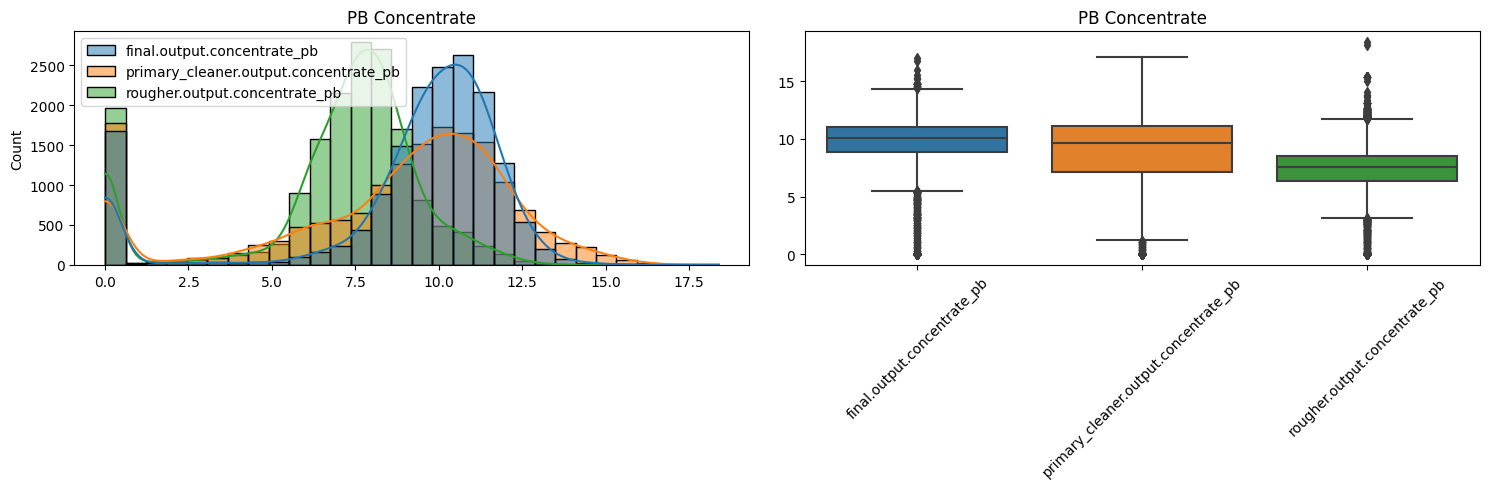

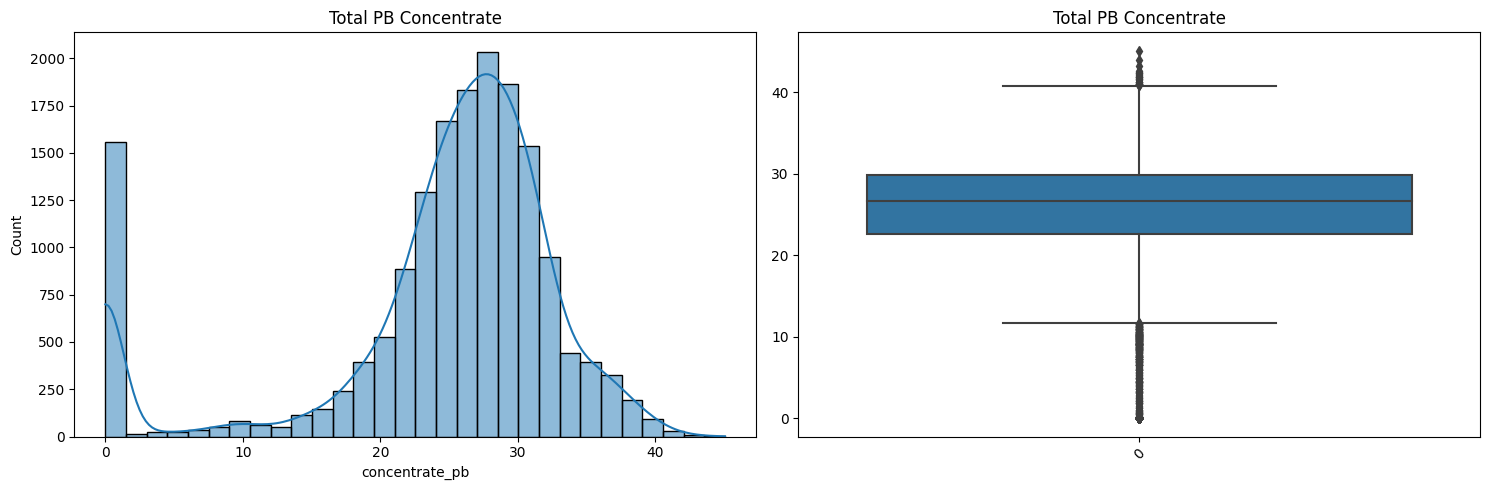

In [19]:
train_metal_total = get_particle_concentrate(df_train)

The graphs show a clear change in concentrate level of each substance during the progression of the process. This is an indication of the function of the process:

Mined ore undergoes primary processing to get the ore mixture or rougher feed, which is the raw material for flotation (also known as the rougher process). After flotation, the material is sent to two-stage purification.

1. Flotation

Gold ore mixture is fed into the float banks to obtain rougher Au concentrate and rougher tails (product residues with a low concentration of valuable metals).

The stability of this process is affected by the volatile and non-optimal physicochemical state of the flotation pulp (a mixture of solid particles and liquid).

2. Purification

The rougher concentrate undergoes two stages of purification. After purification, we have the final concentrate and new tails.

A change in concentration is expected - either an increase or decreasee resulting from the purification reaction.

Of note is the high number of zero values of concentration measured. These may indicate an error in measurement or failure in the process and will need to be addressed.

<div class="alert alert-block alert-danger">
<b>Reviewer's comment V1</b> <a class="tocSkip"></a>
    
The graphs are correct. But you forgot to draw a conclusion based on them.
    
</div>

<div class="alert alert-block alert-success">
<b>Reviewer's comment V2</b> <a class="tocSkip"></a>
    
Thank you!
    
</div>

### Compare the feed particle size distributions in the training set and in the test set. If the distributions vary significantly, the model evaluation will be incorrect.

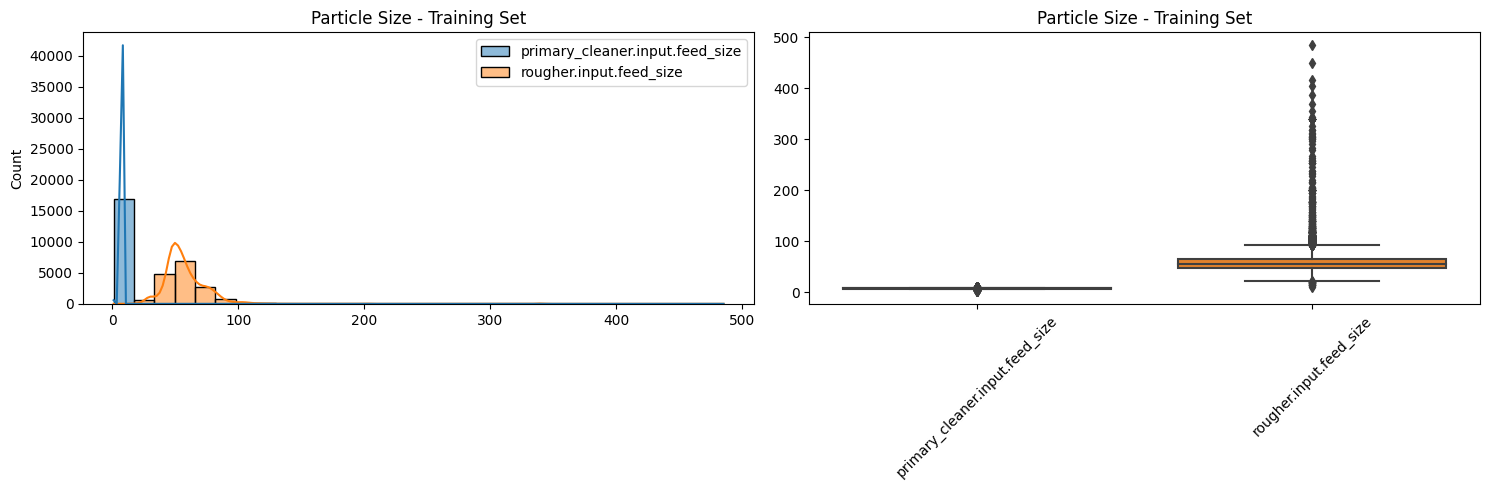

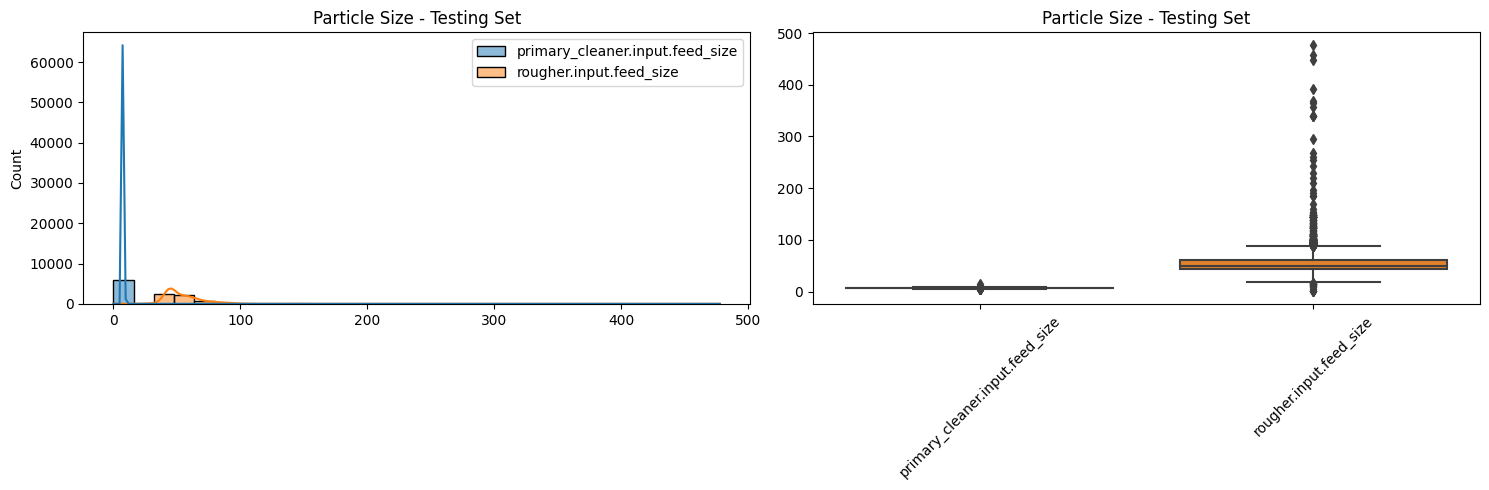

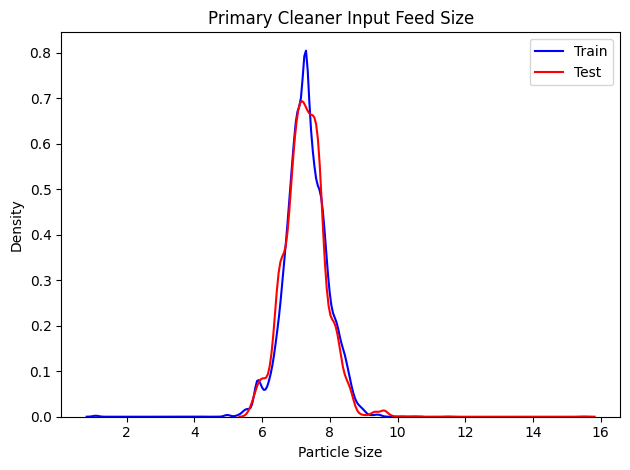

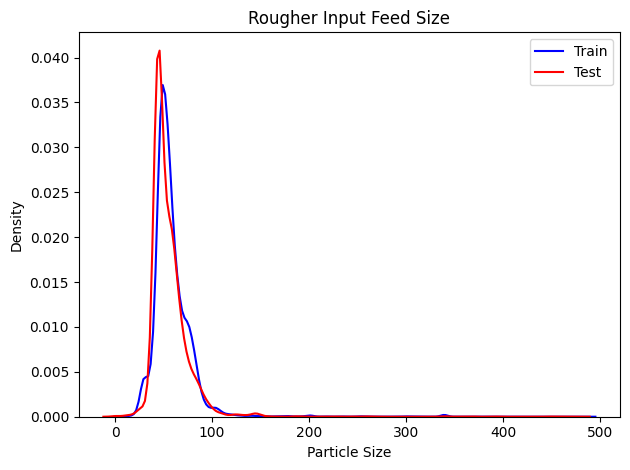

In [20]:
plot_hist_bar(filter_by_cols(df_train, 'feed_size'), 'Particle Size - Training Set')
plot_hist_bar(filter_by_cols(df_test, 'feed_size'), 'Particle Size - Testing Set')

plot_kde_compare(df_train, df_test, 'primary_cleaner.input.feed_size', 'Primary Cleaner Input Feed Size', 'Particle Size')
plot_kde_compare(df_train, df_test, 'rougher.input.feed_size', 'Rougher Input Feed Size', 'Particle Size')

Particle size between training and test sests do not vary significantly. Features will be scaled in subsequent steps.

<div class="alert alert-block alert-success">
<b>Reviewer's comment V1</b> <a class="tocSkip"></a>
    
Well done!
    
</div>

### Consider the total concentrations of all substances at different stages: raw feed, rougher concentrate, and final concentrate. Do you notice any abnormal values in the total distribution? If you do, is it worth removing such values from both samples? Describe the findings and eliminate anomalies. 

In [21]:
def get_stage_concentrate(df, plot=True):
    df_stage_total = pd.DataFrame()
    
    #rougher.output.concentrate
    rougher_output_concentrate = filter_by_cols(df, 'rougher.output.concentrate')
    df_stage_total['rougher.output.concentrate'] = rougher_output_concentrate.sum(axis=1)
    
    #primary_cleaner.output.concentrate
    primary_cleaner_output_concentrate = filter_by_cols(df, 'primary_cleaner.output.concentrate')
    df_stage_total['primary_cleaner.output.concentrate'] = primary_cleaner_output_concentrate.sum(axis=1)
    
    #final.output.concentrate
    final_output_concentrate = filter_by_cols(df, 'final.output.concentrate')
    df_stage_total['final.output.concentrate'] = final_output_concentrate.sum(axis=1)
    
    #added_columns = ['total_rougher_output_concentrate', 'total_primary_cleaner_output_concentrate', 'total_final_output_concentrate']

    if (plot==True) & (len(df_stage_total) > 0):
        plot_hist_bar(rougher_output_concentrate, 'Rougher Output Concentrate')
        plot_hist_bar(df_stage_total['rougher.output.concentrate'], 'Total Rougher Output Concentrate')
        
        plot_hist_bar(primary_cleaner_output_concentrate, 'Primary Cleaner Output Concentrate')
        plot_hist_bar(df_stage_total['primary_cleaner.output.concentrate'], 'Total Primary Cleaner Output Concentrate')
        
        plot_hist_bar(final_output_concentrate, 'Final Output Concentrate')
        plot_hist_bar(df_stage_total['final.output.concentrate'], 'Total Final Output Concentrate')
    
    #return #df, added_columns

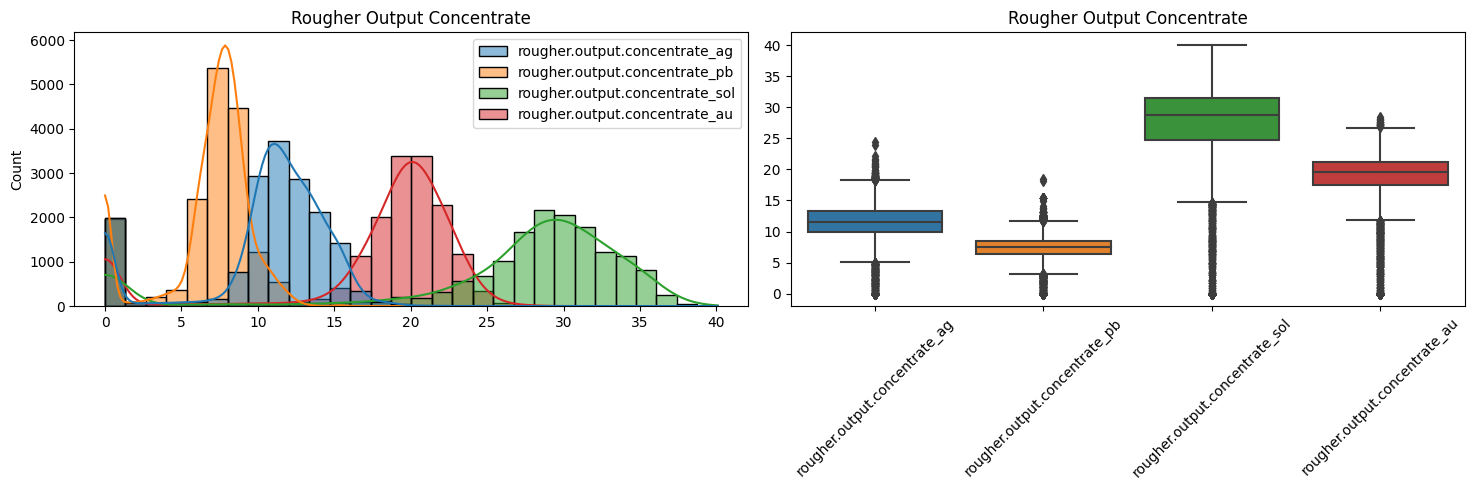

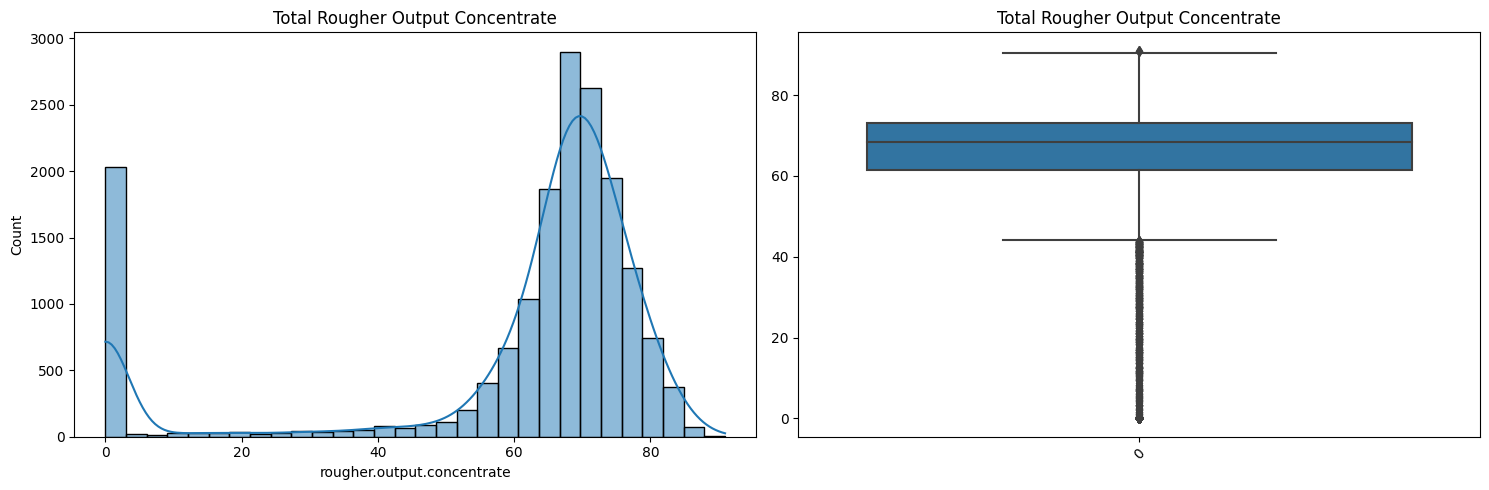

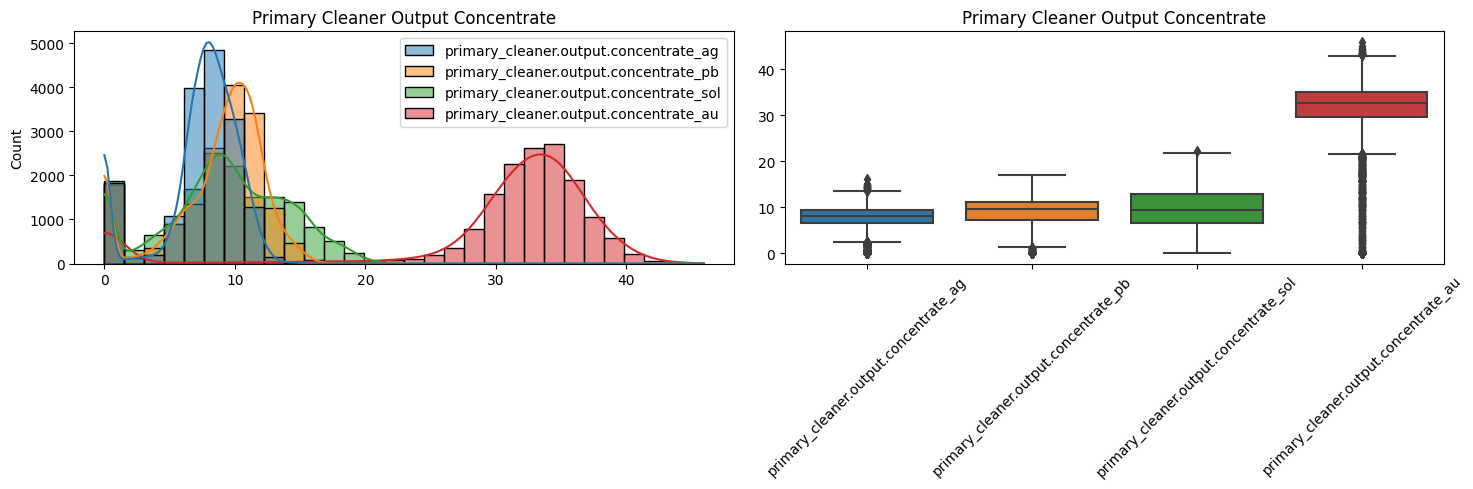

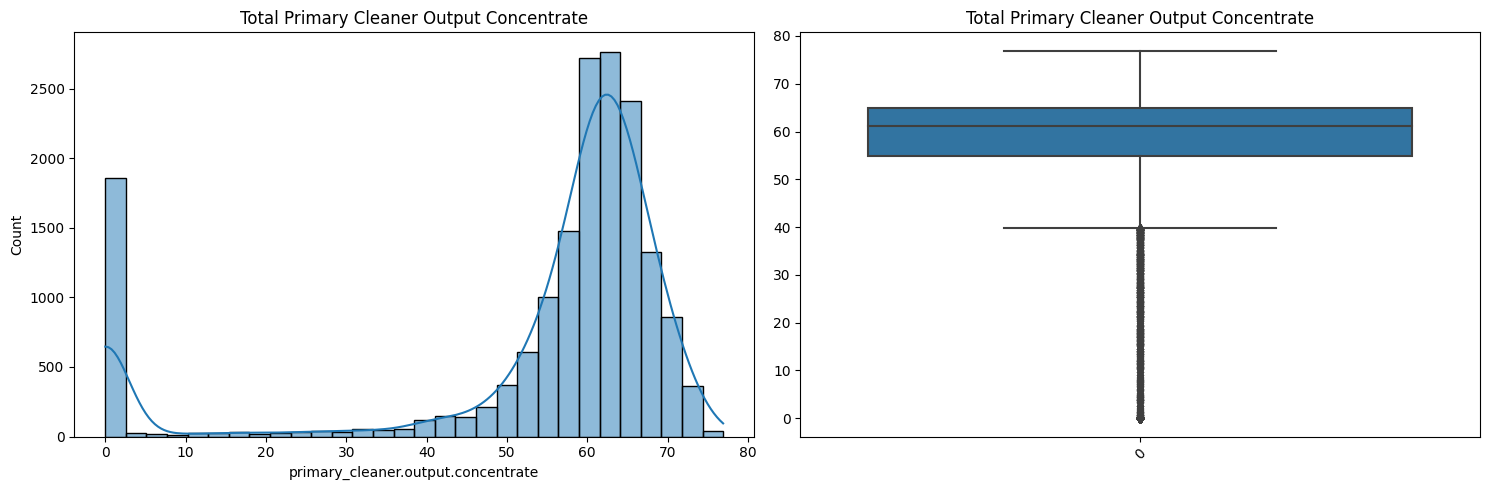

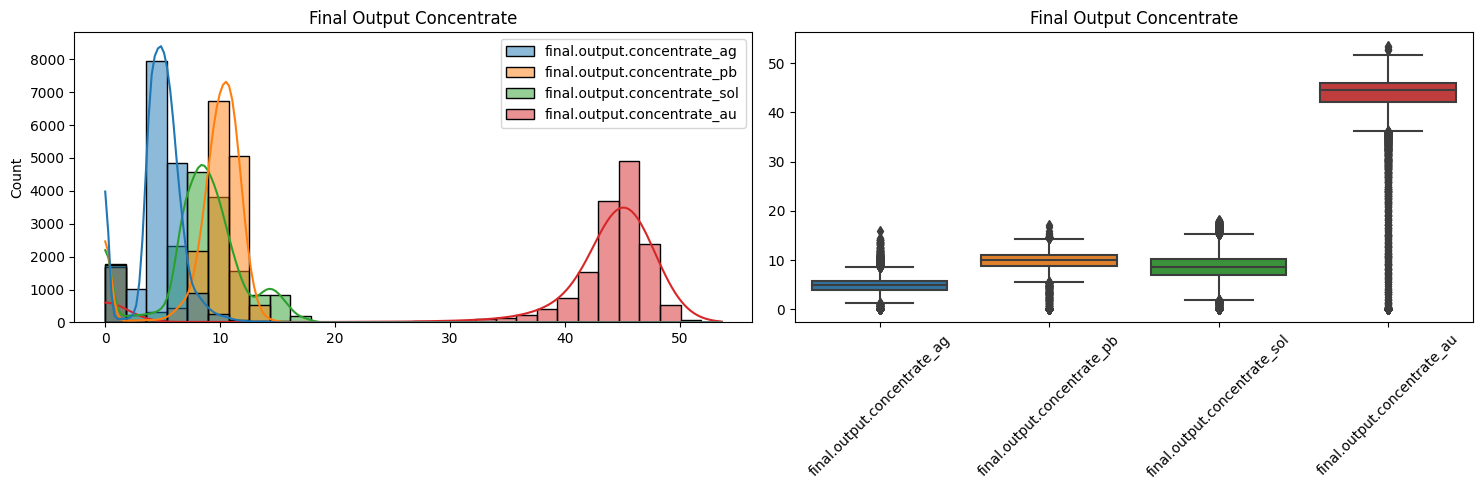

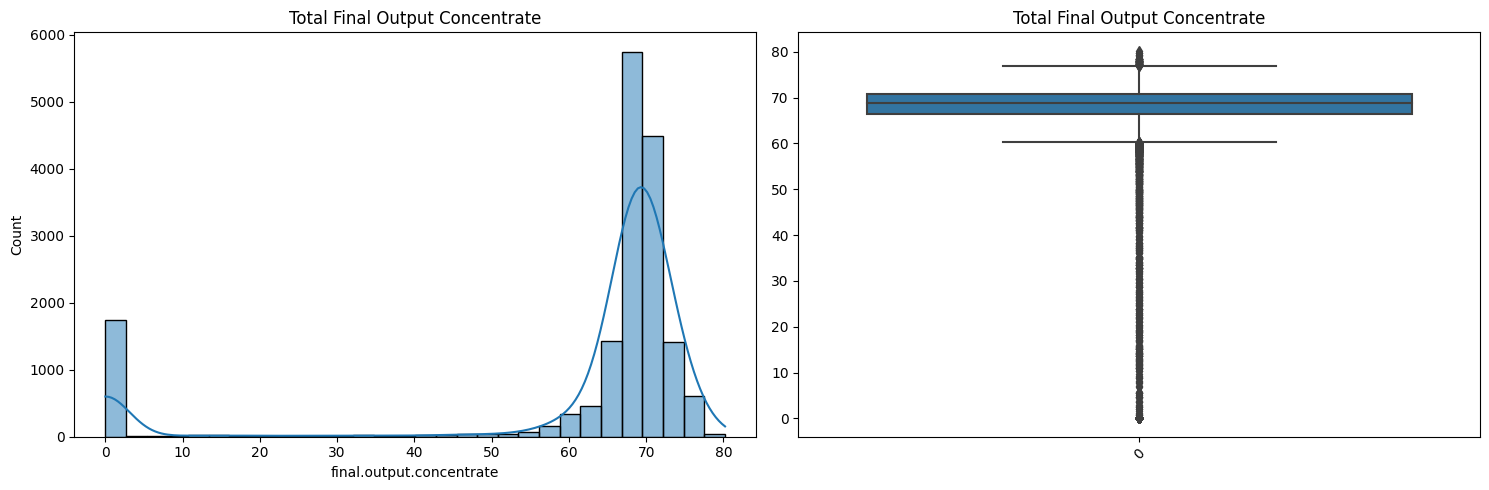

In [22]:
get_stage_concentrate(df_train)

The graphs show a noticable trend where total concentrate at various stages is 0. This may represent an error in the test or with the measurement. For accurate modeling, these issues will need to be addressed.

First erronious data will be removed. Null data points will then be filled.

In [23]:
# make a DF to compare original data to cleaned data:

df_compare = pd.DataFrame()
df_compare['final.output.recovery'] = df_train['final.output.recovery']
df_compare['rougher.output.recovery'] = df_train['rougher.output.recovery']

In [24]:
def drop_zeros(df):
    
    df = df[(df['final.output.concentrate_ag'] >= 1) & (df['final.output.concentrate_pb'] >= 1) & (df['final.output.concentrate_sol'] >=1) & (df['final.output.concentrate_au'] >=1)]
    
    df = df[(df['primary_cleaner.output.concentrate_ag'] >= 1) & (df['primary_cleaner.output.concentrate_pb'] >= 1) & (df['primary_cleaner.output.concentrate_sol'] >= 1) & (df['primary_cleaner.output.concentrate_au'] >= 1)]
    
    df = df[(df['rougher.output.concentrate_ag'] >= 1) & (df['rougher.output.concentrate_pb'] >= 1) & (df['rougher.output.concentrate_sol'] >= 1) & (df['rougher.output.concentrate_au'] >= 1)]
                                                                                                                                                          
    df = df[df['rougher.output.concentrate_au'] >= 1]
    df = df[df['rougher.input.feed_au'] >= 1]
                                                                                                                                                           
    return df

In [25]:
# drop erroneous values first to prevent filling with them
df_train = drop_zeros(df_train)

<div class="alert alert-block alert-success">
<b>Reviewer's comment V1</b> <a class="tocSkip"></a>
    
Great work!
    
</div>

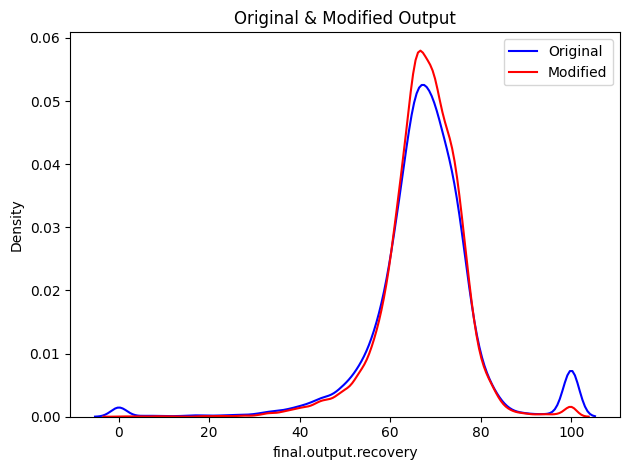

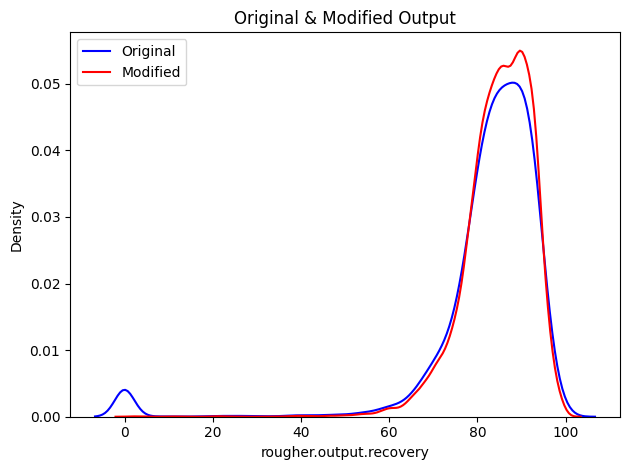

In [26]:
# Verify work

#plot_kde_compare(df0, df1, col, title, xlabel, df0label='Train', df1lavel='Test'):
title = 'Original & Modified Output'
df0label = 'Original'
df1label = 'Modified'

plot_kde_compare(df_compare, df_train, 'final.output.recovery', title,'final.output.recovery',df0label, df1label)
plot_kde_compare(df_compare, df_train, 'rougher.output.recovery', title,'rougher.output.recovery', df0label, df1label)

In [27]:
print(f'Training Set - remaining null values: {df_train.isna().sum().sum()}')

Training Set - remaining null values: 4834


Parameters that are next to each other in terms of time are often similar. To fill missing values ffill will be used. A closer fit was found involving filling by correlation and grouping dates with ffill but this significiantly increased run time for minimal gains.

In [28]:
# fill missing values

def fill_feature_na(df):
    # Fill NaN values in each column
    target_cols = ['rougher.output.recovery', 'final.output.recovery'] # don't change values
    for col in df.columns:
        if col not in target_cols:
            df[col] = df[col].ffill()
    return df

df_train = fill_feature_na(df_train)

In [29]:
# drop NA values from targets:

def drop_target_na(df):
    target_cols = ['rougher.output.recovery', 'final.output.recovery']
    df = df.dropna(subset=target_cols)
    return df

df_train = drop_target_na(df_train)

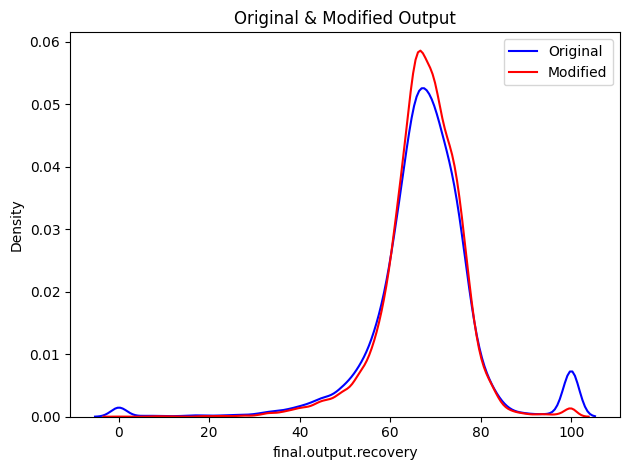

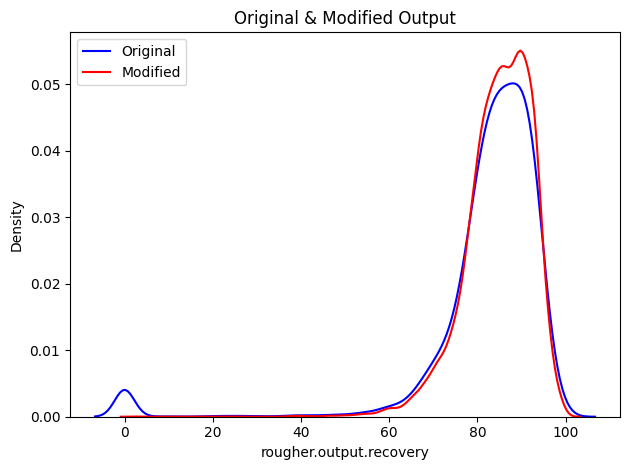

In [30]:

title = 'Original & Modified Output'
df0label = 'Original'
df1label = 'Modified'

plot_kde_compare(df_compare, df_train, 'final.output.recovery', title,'final.output.recovery', df0label, df1label)
plot_kde_compare(df_compare, df_train, 'rougher.output.recovery', title,'rougher.output.recovery', df0label, df1label)

Other methods of handling erronious and missing data points were able to achieve closer results, such as filling using correlation, however these required significant time for minimal gains.
Plotting the original and modified output shows the curve stays relatively the same indicating a close fit.

df_test did not include target columns. In order to complete and validate modeling they must be added. For this, select data from the full set will be merged.

In [31]:
# Adding targets to df_test:

df_filtered = df_full[['date', 'rougher.output.recovery', 'final.output.recovery']]
df_filtered = df_filtered.dropna()
df_test = pd.merge(df_filtered, df_test, how='inner', on='date')

In [32]:
target_cols = ['rougher.output.recovery', 'final.output.recovery']

print((df_test[target_cols] == 0).sum())
print((df_test['rougher.input.feed_au'] ==0).sum())

df_test = df_test[df_test['rougher.output.recovery'] >= 1]
df_test = df_test[df_test['final.output.recovery'] >= 1]
df_test = df_test[df_test['rougher.input.feed_au'] >= 1]



rougher.output.recovery    97
final.output.recovery      40
dtype: int64
0


It is necessary to deal with missing and invalid datapoints with the testing set.

In [33]:
##### DROP ZEROS FROM TARGET COLS
##### THEN FILL NA
print(f'Testing set - missing values: {df_test.isna().sum().sum()}')

df_test = fill_feature_na(df_test)
df_test = drop_target_na(df_test)

Testing set - missing values: 66


In [34]:
# drop date from both
df_train = df_train.drop('date', axis=1)
df_test = df_test.drop('date', axis=1)

As previously discussed, both sets must share the same features and targets. 

In [35]:
# Get uncommon features
uncommon_features = get_uncommon_cols(df_train, df_test, display=False)

# Drop uncommon features
df_train = df_train.drop(uncommon_features, axis=1)

In [36]:
# Verify all major issues have been resolved

explore_df(df_train, 'Training Set', detailed=False)

explore_df(df_test, 'Testing Set', detailed=False)

explore_df(df_full, 'Full Set', detailed=False)
print('The full set has not been modified')

Training Set

Training Set - shape: (13049, 54)
Training Set - Number of duplicates: 0
Training Set - Number of null entries: 0

Testing Set

Testing Set - shape: (5154, 54)
Testing Set - Number of duplicates: 0
Testing Set - Number of null entries: 0

Full Set

Full Set - shape: (22716, 87)
Full Set - Number of duplicates: 0
Full Set - Number of null entries: 36587

The full set has not been modified


In [37]:
# Creating Targets

targets = ["rougher.output.recovery", "final.output.recovery"]

# Splitting df_train

features_train = df_train.drop(targets, axis=1).reset_index(drop=True)

targets_train = df_train[targets].reset_index(drop=True)

# Spltting df_test

features_test = df_test.drop(targets, axis=1).reset_index(drop=True)

targets_test = df_test[targets].reset_index(drop=True)

In [38]:
# Scale features

scaler = StandardScaler()
scaler.fit(features_train)

# Standardize all the features
pd.options.mode.chained_assignment = None
features_train_scaled = scaler.transform(features_train)
features_test_scaled = scaler.transform(features_test)

Any issues identified in the training and testing set have been resolved. Features from both sets match and have been scaled.

<div class="alert alert-block alert-success">
<b>Reviewer's comment V1</b> <a class="tocSkip"></a>
    
Everything is correct. Good job!
    
</div>

## Build the model

### Write a function to calculate the final sMAPE value.

Evaluation metric
To solve the problem, we will need a new metric. It is called sMAPE, symmetric Mean Absolute Percentage Error. 

It is similar to MAE, but is expressed in relative values instead of absolute ones. Why is it symmetrical? It equally takes into account the scale of both the target and the prediction.

Here’s how sMAPE is calculated:

In [39]:
# Function to calculate smape 
def calculate_smape(target: pd.Series, prediction: pd.Series) -> float:
    
    N = len(target)
    smape = ((abs(target-prediction) / ((abs(target) + abs(prediction)) / 2)).sum() / N) * 100
    
    return smape


In [40]:
# Function to final smape 
def calculate_final_smape(smape_rougher: float, smape_final: float) -> float:
    
    final_smape = (0.25 * smape_rougher) + (0.75 * smape_final)
    return final_smape

In [41]:
smape_score = make_scorer(calculate_smape)

### Train different models. Evaluate them using cross-validation. Pick the best model and test it using the test sample. Provide findings.

In [42]:
# Create a DF to track results
result_cols = ['title', 'target', 'smape', 'model']

results = pd.DataFrame(columns=result_cols)

In [43]:
# A function to plot results:

def plot_results(results, title):

    ymin = (math.floor(results['smape'].min())-0.5)
    ymax = (math.ceil(results['smape'].max())+0.5)

    sns.barplot(data=results, x='title', y='smape')
    plt.xticks(rotation=45, ha='right')
    #plt.ylim(ymin, ymax)
    plt.title(title)
    plt.show()


In [44]:
# Build Decision Tree Regressor:

def decision_tree(features_train_scaled, targets_train, col):
    best_model = None
    best_result = 10000
    best_depth = 0
    best_cross_valid_score = -10000
    for depth in range(1, 11): # choose hyperparameter range
        model = DecisionTreeRegressor(max_depth=depth, random_state=12345) # train model on training set
        
        cross_valid_score = cross_val_score(model, features_train_scaled, targets_train[col], cv=5, scoring=smape_score)
        
        if (best_cross_valid_score < cross_valid_score.mean()):
            best_model = model
            best_cross_valid_score = cross_valid_score.mean()
            best_depth = depth
    print(f'Best score:  {best_cross_valid_score:.2f}')
    print(f'Best depth: {best_depth}')

    return best_cross_valid_score, best_model

In [45]:
# Run Decision Tree Regressor:

title = 'Decision Tree Regressor - Training Set'

target = 'rougher.output.recovery'
print(f'{title}, target = {target}')
best_score, best_model = decision_tree(features_train_scaled, targets_train, target)
results.loc[len(results)] = [title, target, best_score, best_model]
print()

target = 'final.output.recovery'
print(f'{title}, target = {target}')
best_score, best_model = decision_tree(features_train_scaled, targets_train, target)
results.loc[len(results)] = [title, target, best_score, best_model]
print()

Decision Tree Regressor - Training Set, target = rougher.output.recovery
Best score:  12.01
Best depth: 7

Decision Tree Regressor - Training Set, target = final.output.recovery
Best score:  11.13
Best depth: 10



In [46]:
# Build Linear Regression:

def linear_regressor(features_train_scaled, targets_train, col):
    model = LinearRegression()
    cross_valid_score = cross_val_score(model, features_train_scaled, targets_train[col], cv=5, scoring=smape_score)
    
    print(f'Best score: {cross_valid_score.mean():.2f}')
    return cross_valid_score.mean(), model


In [47]:
# Run Linear Regressor:

title = 'Linear Regressor - Training Set'

target = 'rougher.output.recovery'
print(f'{title}, target = {target}')
best_score, best_model = linear_regressor(features_train_scaled, targets_train, target)
results.loc[len(results)] = [title, target, best_score, best_model]
print()

target = 'final.output.recovery'
print(f'{title}, target = {target}')
best_score, best_model = linear_regressor(features_train_scaled, targets_train, target)
results.loc[len(results)] = [title, target, best_score, best_model]

Linear Regressor - Training Set, target = rougher.output.recovery
Best score: 7.09

Linear Regressor - Training Set, target = final.output.recovery
Best score: 10.11


In [48]:
# Build Random Forest Regression:

def random_forest(features_train_scaled, targets_train, col):

    best_model = None
    best_est = 0
    best_depth = 0
    best_cross_valid_score = -10000
    
    for est in range(10, 50, 10):
        for depth in range(1, 8):

            model = RandomForestRegressor(n_estimators=est, max_depth=depth, random_state=12345)
    
            # Cross validate the current model using smape as scoring function
            cross_valid_score = cross_val_score(model, features_train_scaled, targets_train[col], cv=3, scoring=smape_score)
            ##### ^^^^^ DROPPED CV=5 TO CV=3 TO INCREASE SPEED ^^^^^ #####
    
            # Check for the best model until the current iteration
            if(best_cross_valid_score < cross_valid_score.mean()):
                best_cross_valid_score = cross_valid_score.mean()
                best_est = est
                best_depth = depth
                best_model = model

    print(f'Best depth {best_depth}')
    print(f'Best  no of estimators {best_est}')
    print(f'Best score {best_cross_valid_score:.2f}')
    
    return best_cross_valid_score, best_model



In [49]:
# Run Random Forest Regression:

title = 'Random Forest - Training Set'

target = 'rougher.output.recovery'
print(f'{title}, target = {target}')
best_score, best_model = random_forest(features_train_scaled, targets_train, target)
results.loc[len(results)] = [title, target, best_score, best_model]
print()

target = 'final.output.recovery'
print(f'{title}, target = {target}')
best_score, best_model = random_forest(features_train_scaled, targets_train, target)
results.loc[len(results)] = [title, target, best_score, best_model]

##### ^^^^^ HIDDEN TO SAVE RUNTIME ^^^^^ #####

Random Forest - Training Set, target = rougher.output.recovery
Best depth 1
Best  no of estimators 10
Best score 8.74

Random Forest - Training Set, target = final.output.recovery
Best depth 3
Best  no of estimators 10
Best score 11.33


To summarize the results:

In [50]:
print(results[['title', 'target', 'smape']])

                                    title                   target      smape
0  Decision Tree Regressor - Training Set  rougher.output.recovery  12.010854
1  Decision Tree Regressor - Training Set    final.output.recovery  11.133917
2         Linear Regressor - Training Set  rougher.output.recovery   7.089978
3         Linear Regressor - Training Set    final.output.recovery  10.114332
4            Random Forest - Training Set  rougher.output.recovery   8.741200
5            Random Forest - Training Set    final.output.recovery  11.333091


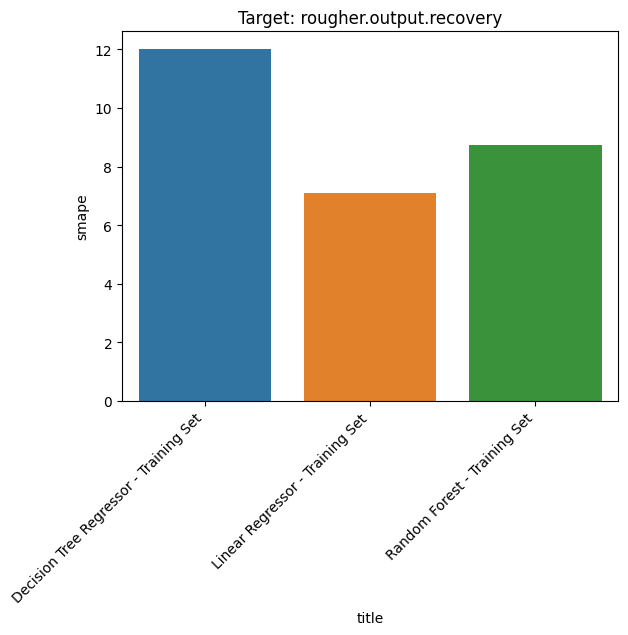

In [51]:
plot_results(results[results['target'] == 'rougher.output.recovery'], 'Target: rougher.output.recovery')

The best result for the training set target rougher.output.recovery is linear regression with a score of 7.09.

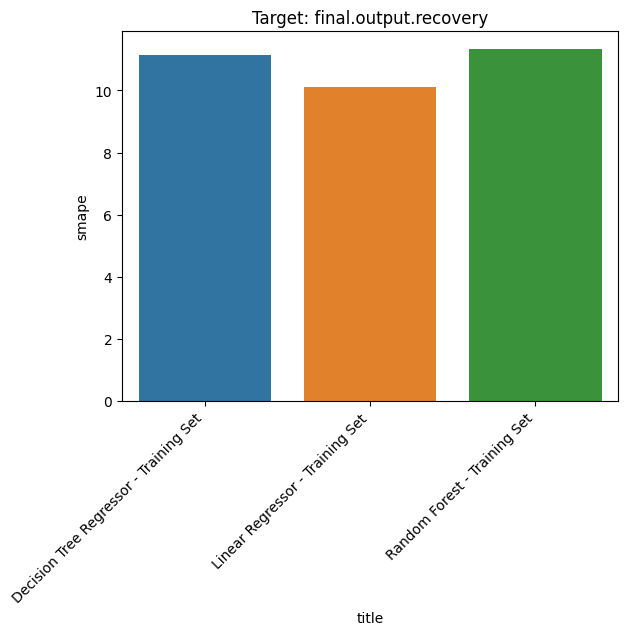

In [52]:
plot_results(results[results['target'] == 'final.output.recovery'], 'Target: final.output.recovery')

In [53]:
# Create a DF to track results
result_cols = ['title', 'target', 'mae', 'rmse', 'smape']

results_final = pd.DataFrame(columns=result_cols)


In [54]:
def linear_regression_final(model, feature_train, target_train, feature_test, target_test, target):
    model.fit(feature_train, target_train[target])
    predictions = model.predict(feature_test)
    mae = mean_absolute_error(target_test[target], predictions)
    rmse = np.sqrt(mean_squared_error(target_test[target], predictions))
    smape = calculate_smape(target_test[target], predictions)

    print(f'MAE: {mae:.2f}')
    print(f'RMSE: {rmse:.2f}')
    print(f'sMAPE: {smape:.2f}')
    
    return mae, rmse, smape

In [55]:
# A function to retrieve model:

def get_model(results, title, target):
    condition0 = results['title'] == title
    condition1 = results['target'] == target
    condition = condition0 & condition1

    model = results.loc[condition, 'model'].iloc[0]

    return model

In [57]:
# Retrieve model and run with the testing set:

title = 'Linear Regressor - Training Set'
target = 'rougher.output.recovery'

model = get_model(results, title, target)

print(f'{title} - {target}')
print()
mae, rmse, smape_rougher = linear_regression_final(model, features_train_scaled, targets_train, features_test_scaled, targets_test, target)

results_final.loc[len(results_final)] = [title, target, mae, rmse, smape_rougher]

Linear Regressor - Training Set - rougher.output.recovery

MAE: 4.13
RMSE: 5.57
sMAPE: 4.96


In [58]:
# Retrieve model and run with the testing set:

title = 'Linear Regressor - Training Set'
target = 'final.output.recovery'

model = get_model(results, title, target)

print(f'{title} - {target}')
print()
mae, rmse, smape_final = linear_regression_final(model, features_train_scaled, targets_train, features_test_scaled, targets_test, target)

results_final.loc[len(results_final)] = [title, target, mae, rmse, smape_rougher]

Linear Regressor - Training Set - final.output.recovery

MAE: 5.32
RMSE: 7.47
sMAPE: 7.92


In [59]:
# Get final smape of final model:

final_smape_model = calculate_final_smape(smape_rougher, smape_final)

print(f'The final smape is found to be:')
print(final_smape_model)


The final smape is found to be:
7.179980150056615


Dummy regression will be used to verify the final models.

In [60]:
# Create a dummy model function

def dummy_model(feature_train, target_train, feature_test, target_test, target):
    dummy_model = DummyRegressor()
    dummy_model.fit(feature_train, target_train[target])
    predictions = dummy_model.predict(feature_test)
    
    mae = mean_absolute_error(target_test[target], predictions)
    rmse = np.sqrt(mean_squared_error(target_test[target],  predictions))
    smape = calculate_smape(target_test[target],  predictions)
    
    print(f'MAE: {mae:.2f}')
    print(f'RMSE: {rmse:.2f}')
    print(f'sMAPE: {smape:.2f}')
    
    return mae, rmse, smape

In [61]:
# Run dummy model with the rougher target

title = 'Dummy Regressor'
target = 'rougher.output.recovery'

print(f'{title} - {target}')
print()
mae, rmse, smape_rougher = dummy_model(features_train_scaled, targets_train, features_test_scaled, targets_test, target)

results_final.loc[len(results_final)] = [title, target, mae, rmse, smape_rougher]

Dummy Regressor - rougher.output.recovery

MAE: 4.32
RMSE: 5.98
sMAPE: 5.13


In [62]:
# Run dummy model with final target

title = 'Dummy Regressor'
target = 'final.output.recovery'

print(f'{title} - {target}')
print()
mae, rmse, smape_final = dummy_model(features_train_scaled, targets_train, features_test_scaled, targets_test, target)

results_final.loc[len(results_final)] = [title, target, mae, rmse, smape_rougher]

Dummy Regressor - final.output.recovery

MAE: 5.58
RMSE: 7.59
sMAPE: 8.31


In [63]:
final_smape_dummy = calculate_final_smape(smape_rougher, smape_final)
print('The final dummy smape is found to be:')
print(final_smape_dummy)

The final dummy smape is found to be:
7.514426518719772


In [64]:
# Comparing the model results to the dummy results:
print(results_final)

                             title                   target       mae  \
0  Linear Regressor - Training Set  rougher.output.recovery  4.130878   
1  Linear Regressor - Training Set    final.output.recovery  5.317851   
2                  Dummy Regressor  rougher.output.recovery  4.323868   
3                  Dummy Regressor    final.output.recovery  5.583038   

       rmse     smape  
0  5.573618  4.964565  
1  7.468290  4.964565  
2  5.982385  5.134548  
3  7.587494  5.134548  


Comparing the model results to the dummy results shows that the model performs better than the dummy, validating the process.

# Conclusion:

All steps in the procedure have been complete.

1. Prepare the data
- 1.1. Open the files and look into the data.
- 1.2. Check that recovery is calculated correctly. Using the training set, calculate recovery for the rougher.output.recovery feature. Find the MAE between your calculations and the feature values. Provide findings.
- 1.3. Analyze the features not available in the test set. What are these parameters? What is their type?
- 1.4. Perform data preprocessing.
2. Analyze the data
- 2.1. Take note of how the concentrations of metals (Au, Ag, Pb) change depending on the purification stage.
- 2.2. Compare the feed particle size distributions in the training set and in the test set. If the distributions vary significantly, the model evaluation will be incorrect.
- 2.3. Consider the total concentrations of all substances at different stages: raw feed, rougher concentrate, and final concentrate. Do you notice any abnormal values in the total distribution? If you do, is it worth removing such values from both samples? Describe the findings and eliminate anomalies. 
3. Build the model
- 3.1. Write a function to calculate the final sMAPE value.
- 3.2. Train different models. Evaluate them using cross-validation. Pick the best model and test it using the test sample. Provide findings.

A significant amount of zero and null values were found. The zero values were found to be errors from measurements or with the testing and removed. Null values were then filled using ffill as parameters that are next to each other in terms of time are often similar.

Several sacrifices were made during the process to reduce runtime:
- Limited number of charts and graphs during exploratory data analysis.
- Rougher fill methods. Correlation and a grouped ffill were found to be closer fits but caused significant run times.
- Limited number of modeling and hyperparameters.

Three models were trained using the training data. The highest performing for each target was then validated on the testing set and dummy regression with the following results:

Linear Regressor - Training Set - rougher.output.recovery
- MAE: 4.13
- RMSE: 5.57
- sMAPE: 4.96

Linear Regressor - Training Set - final.output.recovery
- MAE: 5.32
- RMSE: 7.47
- sMAPE: 7.92



<div class="alert alert-block alert-danger">
<b>Reviewer's comment V1</b> <a class="tocSkip"></a>
    
You did a great job! Well done! But:

1. You need to do sanity check. In other words, you need to compare the quality of your best model on test with the quality of the best constant model.
2. You need to calculate not only separate smapes but the final smape as well. As I can see you have a function for final smape calculation `calculate_final_smape` but you've never used it.
    
About sanity check. You have this topik in the lesson about supervised learning. Do you know about constant models? These models predict the same constant for any input. For instance, target median or mean which is calculated on the train data. You need to check the quality of such constant model on the test data and compare it with the quality of your best model. You can find such constant models in sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html It's better to make such comparison in any project. Constant model is the simplest baseline. Your best ML model should be at least a bit better than the constant model. Otherwise, your model is useless. So, please, do it.
</div>

<div class="alert alert-block alert-success">
<b>Reviewer's comment V2</b> <a class="tocSkip"></a>
    
Everything is correct now. Great work!
    
</div>